# Import libraries

In [1]:
!pip install --upgrade pip setuptools
!pip install wordcloud
# !pip install lightgbm
!pip install nltk
!pip install imbalanced-learn
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn
!pip install -U Textblob
!python -m textblob.download_corpora
!pip install unidecode
# !pip install lightgbm==2.2.3
!pip install contractions
!pip install scikit-optimize
!pip install scipy

[nltk_data] Downloading package brown to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# import modules
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import nltk
import re
import joblib
import contractions
import scipy.stats

# modules preprocessing
from matplotlib.ticker import FormatStrFormatter 
from matplotlib.colors import LinearSegmentedColormap
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from wordcloud import WordCloud
from collections import Counter
from unidecode import unidecode
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
import contractions
from scipy.stats import randint, uniform

# sentiment & transforming features
from textblob import TextBlob
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler

# algorithms
from sklearn.ensemble import RandomForestClassifier
# import lightgbm as lgb
from sklearn.svm import SVC

# evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, mean_absolute_error,  mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sebastianhaecker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load clean data

In [2]:
df = pd.read_csv('clean_data.csv', index_col=0)
# df = pd.read_csv('/content/drive/MyDrive/3_classes/clean_data.csv', index_col=0)  # running lightgbm in colab

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75790 entries, 0 to 362281
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Age        75790 non-null  object
 1   Reviews    75790 non-null  object
 2   Sex        75790 non-null  object
 3   EaseofUse  75790 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


## Textblob Polarity Score

In [299]:
# # Textblob on the reviews to extract sentiment: the polarity score, RUN ONLY WHEN TESTED WITH POLARITY SCORE
# sentiment_scores = df['Reviews'].apply(lambda x: TextBlob(x).sentiment)
# polarity_scores = sentiment_scores.apply(lambda x: x.polarity)
# # Add polarity scores as predictive features
# df['Polarity_score_review'] = polarity_scores

### Train/Test split

In [4]:
# Split data in train and test
train, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['EaseofUse'])

In [5]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 68211 entries, 233007 to 200930
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Age        68211 non-null  object
 1   Reviews    68211 non-null  object
 2   Sex        68211 non-null  object
 3   EaseofUse  68211 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 7579 entries, 211222 to 44054
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Age        7579 non-null   object
 1   Reviews    7579 non-null   object
 2   Sex        7579 non-null   object
 3   EaseofUse  7579 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 296.1+ KB
None


### Drop features 3th experiment 

In [6]:
# Drop features for experiment 3, DROP ONLY WHEN TESTED WITHOUT ADDITIONAL FEATURES 
train.drop(columns=['Age', 'Sex'], inplace= True)
test.drop(columns=['Age', 'Sex'], inplace= True)

## Undersample train set

In [7]:
# Class imbalance Undersampling the data distribution with RandomUnderSampler
X_train = train.drop(columns=['EaseofUse'])
y_train = train['EaseofUse']
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

train = pd.DataFrame(X_train_resampled, columns=X_train.columns)
train['EaseofUse'] = y_train_resampled
print(train.EaseofUse.value_counts())

EaseofUse
1    7422
2    7422
3    7422
Name: count, dtype: int64


In [8]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 22266 entries, 183081 to 193215
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Reviews    22266 non-null  object
 1   EaseofUse  22266 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 521.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 7579 entries, 211222 to 44054
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Reviews    7579 non-null   object
 1   EaseofUse  7579 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 177.6+ KB
None


### Transform features

In [8]:
# Encode categorical features with dummies encoding en label encoding RUN ONLY WHEN TESTING WITH FEATURES FROM DATASET
# train = pd.get_dummies(train, columns=['Sex'])
# test = pd.get_dummies(test, columns=['Sex'])

# ordinal_encoder = OrdinalEncoder()
# train['Age'] = ordinal_encoder.fit_transform(train[['Age']])
# test['Age'] = ordinal_encoder.transform(test[['Age']])

In [9]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 22266 entries, 183081 to 193215
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Reviews    22266 non-null  object
 1   EaseofUse  22266 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 521.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 7579 entries, 211222 to 44054
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Reviews    7579 non-null   object
 1   EaseofUse  7579 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 177.6+ KB
None


In [10]:
# Apply TF-IDF and ngrams on the review fature to be processed, CHANGE SETTING WHEN RUNNING UNIGRAMS, BIGRAMS OR TOGHETHER 
# tfidf_vectorizer = TfidfVectorizer(use_idf= True,smooth_idf = False, min_df= 0.005) #default
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),smooth_idf = False, min_df= 0.005) #unigrams 
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), use_idf= True,smooth_idf = False, min_df= 0.005) #unigrams and bigrams

# Transform reviews
tfidf_train = tfidf_vectorizer.fit_transform(train['Reviews'])
tfidf_test = tfidf_vectorizer.transform(test['Reviews'])

# Convert to dataframe
X_train_text = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=train.index)
X_test_text = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=test.index)

# Concatenate and make dataframe
train = pd.concat([train.drop(columns='Reviews'), X_train_text], axis=1)
test = pd.concat([test.drop(columns='Reviews'), X_test_text], axis=1)

In [11]:
print (train.shape)
print (test.shape)

(22266, 1098)
(7579, 1098)


In [12]:
# Split the train and test set for prediction in: X_train, y_train, X_test, y_test
X_train = train.drop(columns=['EaseofUse'])
y_train = train['EaseofUse']
X_test = test.drop(columns=['EaseofUse'])
y_test = test['EaseofUse']

In [13]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(22266, 1097)
(22266,)
(7579, 1097)
(7579,)


In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22266 entries, 183081 to 193215
Columns: 1097 entries, 10 to zero
dtypes: float64(1097)
memory usage: 186.5 MB


## RF unigrams, bigrams without additional features 

In [141]:
# Hyperparameter tuning: Randomized search
start_time = time.time()

param_grid = {
    'n_estimators': randint(10, 1000),
    'max_depth': randint(1, 60),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap' : [True, False],
    'criterion': ['gini', 'entropy'], 
}

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf_classifier,
                                   param_distributions=param_grid,
                                   n_iter=100,
                                   cv=k_fold,
                                   scoring = 'neg_mean_absolute_error',
                                   n_jobs=5,
                                   verbose = 5, 
                                   random_state=42)
rf_random.fit(X_train, y_train)

print("Best Parameters:", rf_random.best_params_)
print("Best score found: ",-rf_random.best_score_)
print ('Best estimator:', rf_random.best_estimator_)

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Execution time: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 3/5] END bootstrap=True, criterion=entropy, max_depth=29, min_samples_leaf=8, min_samples_split=6, n_estimators=30;, score=-0.662 total time=   3.8s
[CV 3/5] END bootstrap=True, criterion=entropy, max_depth=19, min_samples_leaf=7, min_samples_split=4, n_estimators=468;, score=-0.653 total time=  37.4s
[CV 5/5] END bootstrap=False, criterion=gini, max_depth=36, min_samples_leaf=8, min_samples_split=9, n_estimators=140;, score=-0.672 total time=  24.7s
[CV 5/5] END bootstrap=False, criterion=gini, max_depth=2, min_samples_leaf=8, min_samples_split=5, n_estimators=423;, score=-0.708 total time=   5.4s
[CV 5/5] END bootstrap=False, criterion=entropy, max_depth=21, min_samples_leaf=1, min_samples_split=5, n_estimators=323;, score=-0.675 total time=  45.9s
[CV 4/5] END bootstrap=False, criterion=gini, max_depth=44, min_samples_leaf=9, min_samples_split=2, n_estimators=484;, score=-0.634 total time= 1.5min
[CV 2/5] END bootstr

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END bootstrap=True, criterion=entropy, max_depth=29, min_samples_leaf=8, min_samples_split=6, n_estimators=30;, score=-0.681 total time=   3.8s
[CV 5/5] END bootstrap=True, criterion=entropy, max_depth=19, min_samples_leaf=7, min_samples_split=4, n_estimators=468;, score=-0.670 total time=  37.1s
[CV 3/5] END bootstrap=False, criterion=gini, max_depth=36, min_samples_leaf=8, min_samples_split=9, n_estimators=140;, score=-0.640 total time=  24.6s
[CV 4/5] END bootstrap=False, criterion=gini, max_depth=2, min_samples_leaf=8, min_samples_split=5, n_estimators=423;, score=-0.671 total time=   5.5s
[CV 4/5] END bootstrap=False, criterion=entropy, max_depth=21, min_samples_leaf=1, min_samples_split=5, n_estimators=323;, score=-0.632 total time=  46.3s
[CV 5/5] END bootstrap=False, criterion=gini, max_depth=44, min_samples_leaf=9, min_samples_split=2, n_estimators=484;, score=-0.673 total time= 1.5min
[CV 5/5] END bootstrap=True, criterion=gini, max_depth=42, min_samples_leaf=3, min_

In [142]:
# Save Randomized and 5CV results 
RF_nofeat_UBT_CV = pd.DataFrame(rf_random.cv_results_)
RF_nofeat_UBT_CV.to_csv('RF_nofeat_UBT_CV.csv', index=False)
box_fig = pd.read_csv('RF_nofeat_UBT_CV.csv')

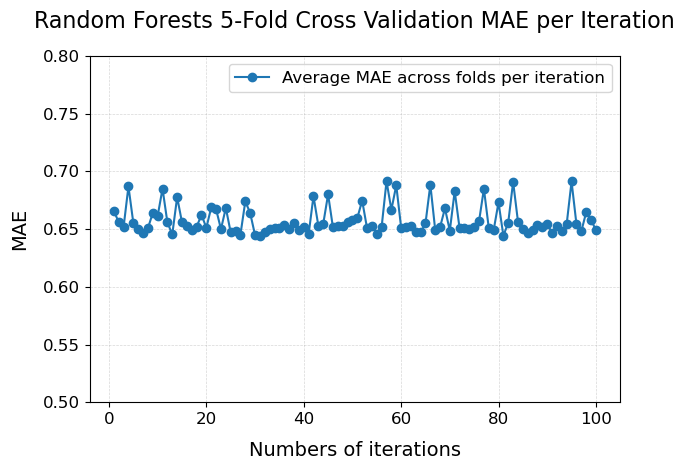

In [143]:
# Plot MAE scores average per cross validation
cv_scores = -box_fig['mean_test_score']
plt.plot(range(1, len(cv_scores) + 1), cv_scores, '-o', label='Average MAE across folds per iteration', color='#1f77b4')

plt.xlabel('Numbers of iterations', fontsize=14, labelpad=10)
plt.ylabel('MAE', fontsize=14, labelpad=10)
plt.title('Random Forests 5-Fold Cross Validation MAE per Iteration', fontsize=16, pad=20)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0.5, 0.8)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('AVG_Iterations.png', dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

In [144]:
# Trained Random Forests predict test data with best estimator
best_estimator = rf_random.best_estimator_
y_pred = best_estimator.predict(X_test)

Test MAE: 0.640
Test RMSE: 0.985
Test CWK: 0.304


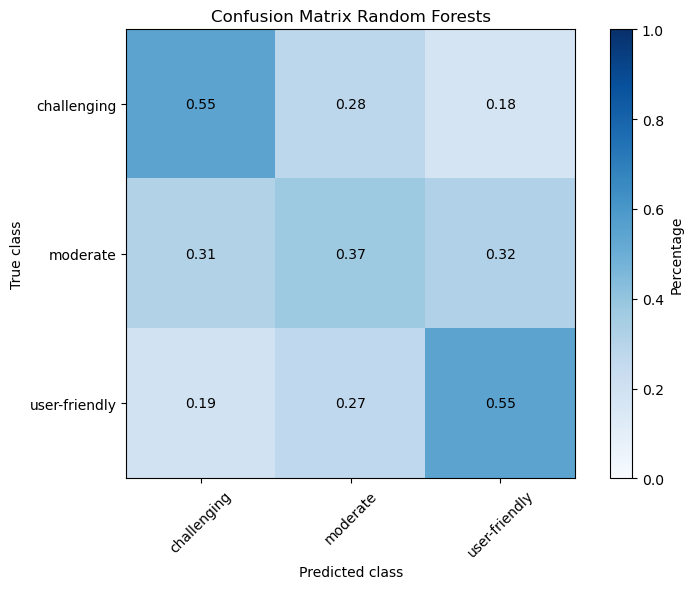

In [145]:
# Evaluation trained best estimator Random Forests
rf_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {rf_mae:.3f}')
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = rf_mse ** 0.5
print(f'Test RMSE: {rf_rmse:.3f}')
rf_kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Test CWK: {rf_kappa:.3f}')

# Confusion matrix
class_labels = {1: 'challenging', 2: 'moderate', 3: 'user-friendly'}
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_percent, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix Random Forests')
plt.colorbar(label='Percentage')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix_percent[i, j]:.2f}', ha='center', va='center', color='black')

plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(np.arange(len(class_labels)), [class_labels[i] for i in sorted(class_labels)], rotation=45)
plt.yticks(np.arange(len(class_labels)), [class_labels[i] for i in sorted(class_labels)])

plt.savefig('RFConfusionMatrix.png', dpi=300, bbox_inches='tight')  # Save as PNG
plt.tight_layout()
plt.show()

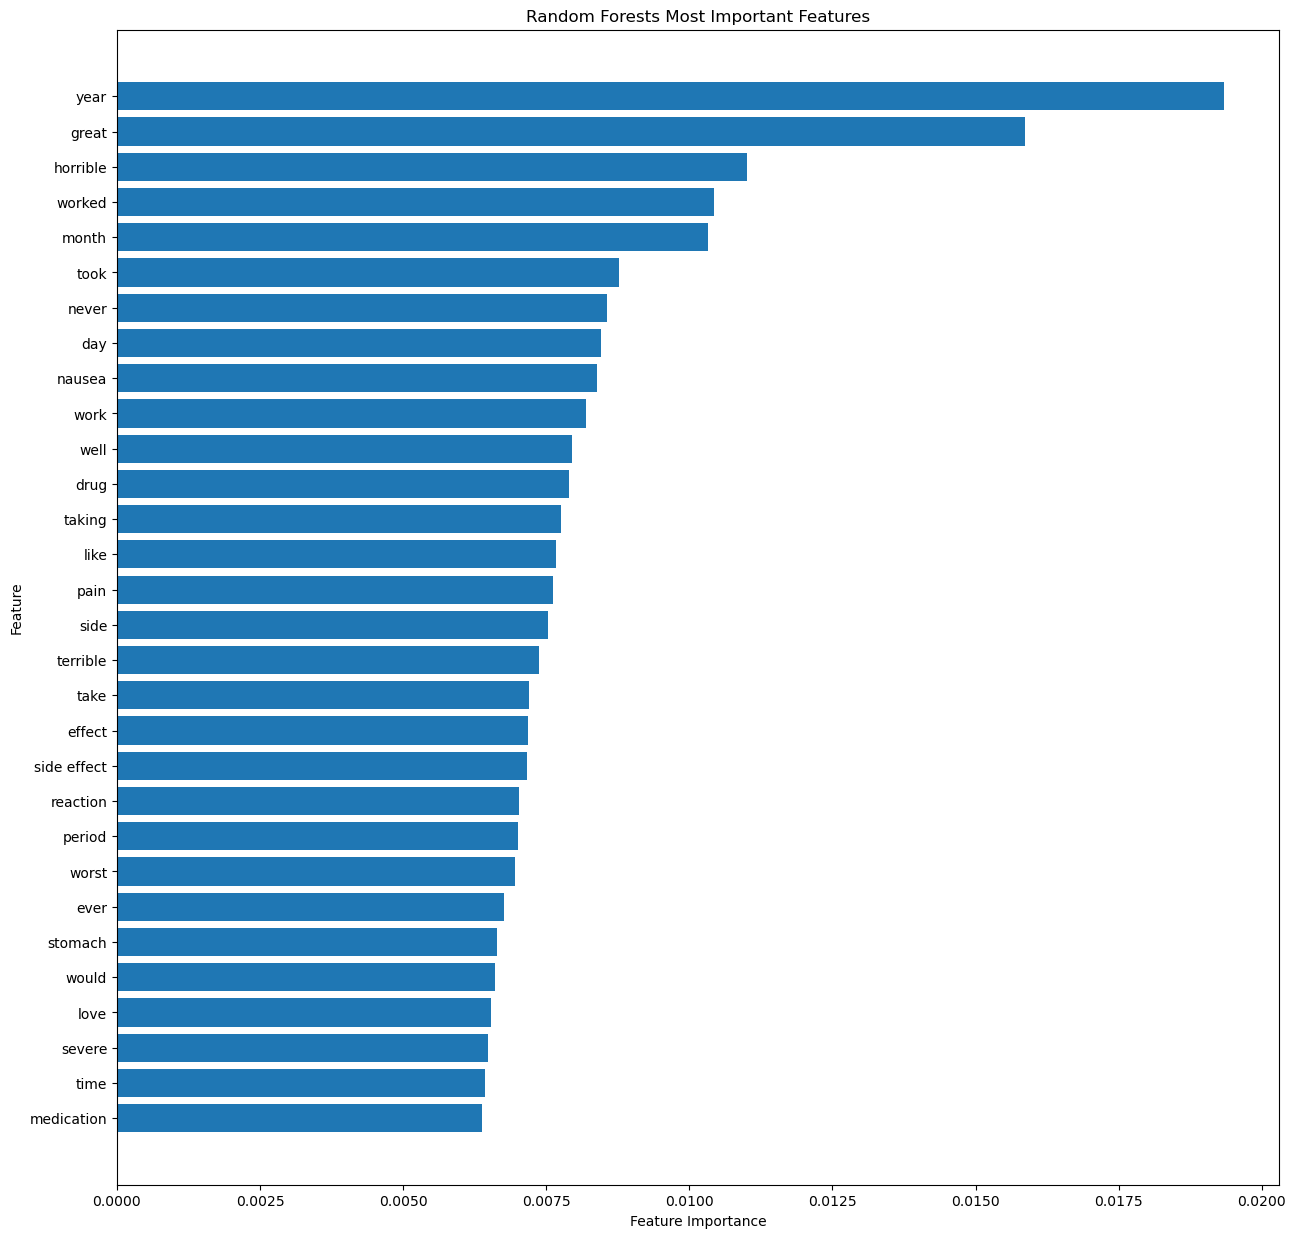

In [146]:
# Feature importance Random Forests
feature_importance = best_estimator.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Top 30
n = 30
plt.figure(figsize=(15, 15))
plt.barh(range(n), feature_importance_df['Importance'].head(n), align='center', color='#1f77b4')
plt.yticks(range(n), feature_importance_df['Feature'].head(n))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forests Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to display features in descending order
plt.savefig('Feature importance.png', dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

## LightGBM with unigrams and bigrams without features 'Age', 'Gender'

In [20]:
# Hyperparameter tuning Randomized search
start_time = time.time()


param_grid = {
    'objective': ['multiclass'],
    'verbose': [-1],
    'num_class': [3],
    'boosting_type': ['gbdt'],
    'num_leaves': list(range(10, 201)),
    'learning_rate': [i/100 for i in range(1, 51)],
    'feature_fraction': [i/10 for i in range(5, 10)],
    'bagging_fraction': [i/10 for i in range(5, 10)],
    'bagging_freq': list(range(1, 11)),
    'min_data_in_leaf': list(range(5, 31)),
    'lambda_l1': [i/10 for i in range(11)],
    'lambda_l2': [i/10 for i in range(11)],
    'max_depth': list(range(5, 71)),
    'min_gain_to_split': [i/100 for i in range(5, 31)],
}

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lgbm_classifier = lgb.LGBMClassifier(random_state=42)
lgbm_random = RandomizedSearchCV(estimator=lgbm_classifier,
                                   param_distributions=param_grid,
                                   n_iter=100,
                                   cv=k_fold,
                                   scoring = 'neg_mean_absolute_error',
                                   random_state=42,
                                   verbose = 3)
lgbm_random.fit(X_train, y_train)



print("Best Parameters:", lgbm_random.best_params_)
print("Best score found: ",-lgbm_random.best_score_)
print ('Best estimator:', lgbm_random.best_estimator_)

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Execution time: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END bagging_fraction=0.6, bagging_freq=5, boosting_type=gbdt, feature_fraction=0.6, lambda_l1=0.7, lambda_l2=0.2, learning_rate=0.38, max_depth=55, min_data_in_leaf=22, min_gain_to_split=0.23, num_class=3, num_leaves=52, objective=multiclass, verbose=-1;, score=-0.691 total time=  26.7s
[CV 2/5] END bagging_fraction=0.6, bagging_freq=5, boosting_type=gbdt, feature_fraction=0.6, lambda_l1=0.7, lambda_l2=0.2, learning_rate=0.38, max_depth=55, min_data_in_leaf=22, min_gain_to_split=0.23, num_class=3, num_leaves=52, objective=multiclass, verbose=-1;, score=-0.682 total time=  20.1s
[CV 3/5] END bagging_fraction=0.6, bagging_freq=5, boosting_type=gbdt, feature_fraction=0.6, lambda_l1=0.7, lambda_l2=0.2, learning_rate=0.38, max_depth=55, min_data_in_leaf=22, min_gain_to_split=0.23, num_class=3, num_leaves=52, objective=multiclass, verbose=-1;, score=-0.672 total time=  19.1s
[CV 4/5] END bagging_fraction=0.6, bagging_fre

In [21]:
# Save Randomized and 5CV results
LGBM_nofeat_CV = pd.DataFrame(lgbm_random.cv_results_)
LGBM_nofeat_CV.to_csv('/content/drive/MyDrive/3_classes/LGBM_nofeat_CV.csv', index=False)
box_fig = pd.read_csv('/content/drive/MyDrive/3_classes/LGBM_nofeat_CV.csv')

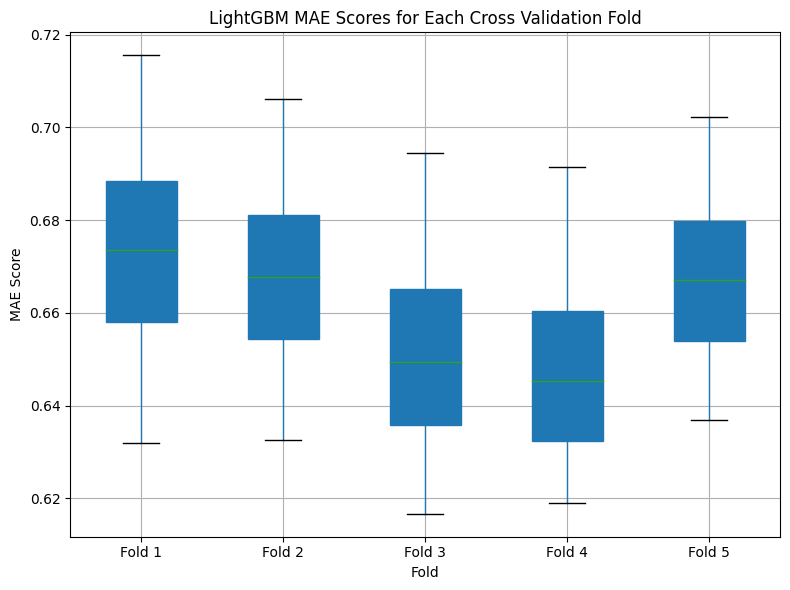

In [22]:
# Boxplot MAE Scores for each fold
plt.figure(figsize=(8, 6))
numeric_cols = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
box_fig[numeric_cols] = box_fig[numeric_cols].abs()
bp = box_fig.boxplot(column=numeric_cols, patch_artist=True)
plt.xlabel('Fold')
plt.ylabel('MAE Score')
plt.title('LightGBM MAE Scores for Each Cross Validation Fold')
plt.xticks(ticks=range(1, 6), labels=[f'Fold {i+1}' for i in range(5)])
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/3_classes/MAE_perFold.png', dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

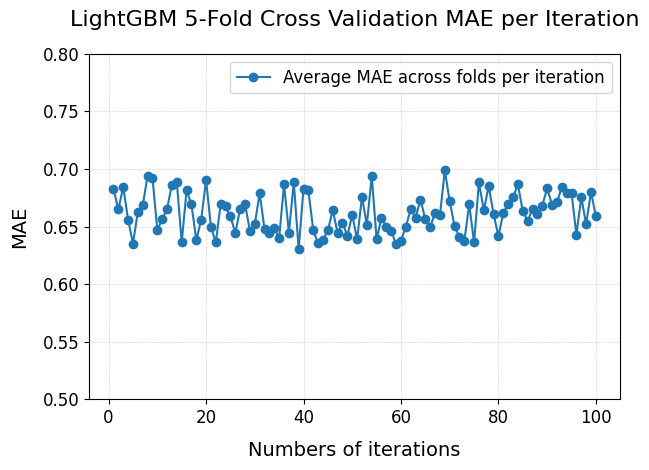

In [23]:
# Plot MAE scores average per cross validation
cv_scores = -box_fig['mean_test_score']
plt.plot(range(1, len(cv_scores) + 1), cv_scores, '-o', label='Average MAE across folds per iteration', color='#1f77b4')


plt.xlabel('Numbers of iterations', fontsize=14, labelpad=10)
plt.ylabel('MAE', fontsize=14, labelpad=10)
plt.title('LightGBM 5-Fold Cross Validation MAE per Iteration', fontsize=16, pad=20)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0.5, 0.8)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/3_classes/LGBM_avg_mae_iteration', dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

In [24]:
# Trained LGBM predict test data with best estimator
lgb_random1 = lgbm_random.best_estimator_
y_pred = lgb_random1.predict(X_test)

Test MAE: 0.634
Test RMSE: 0.972
Test CWK: 0.314


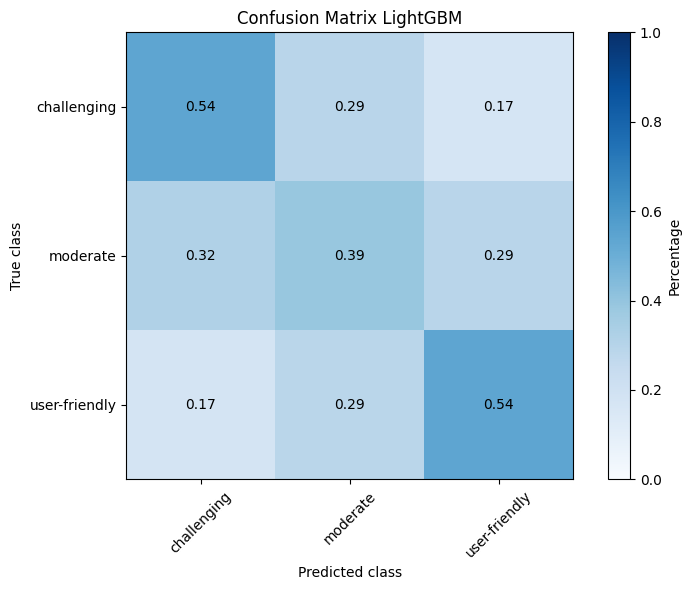

In [25]:
# Evaluation
lgbm_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {lgbm_mae:.3f}')
lgbm_mse = mean_squared_error(y_test, y_pred)
lgbm_rmse = lgbm_mse ** 0.5
print(f'Test RMSE: {lgbm_rmse:.3f}')
lgbm_kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Test CWK: {lgbm_kappa:.3f}')

# Confusion matrix
class_labels = {1: 'challenging', 2: 'moderate', 3: 'user-friendly'}
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_percent, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix LightGBM')
plt.colorbar(label='Percentage')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix_percent[i, j]:.2f}', ha='center', va='center', color='black')

plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(np.arange(len(class_labels)), [class_labels[i] for i in sorted(class_labels)], rotation=45)
plt.yticks(np.arange(len(class_labels)), [class_labels[i] for i in sorted(class_labels)])

plt.savefig('/content/drive/MyDrive/3_classes/LGBM_confusionmatrix.png', dpi=300, bbox_inches='tight')  # Save as PNG
plt.tight_layout()
plt.show()

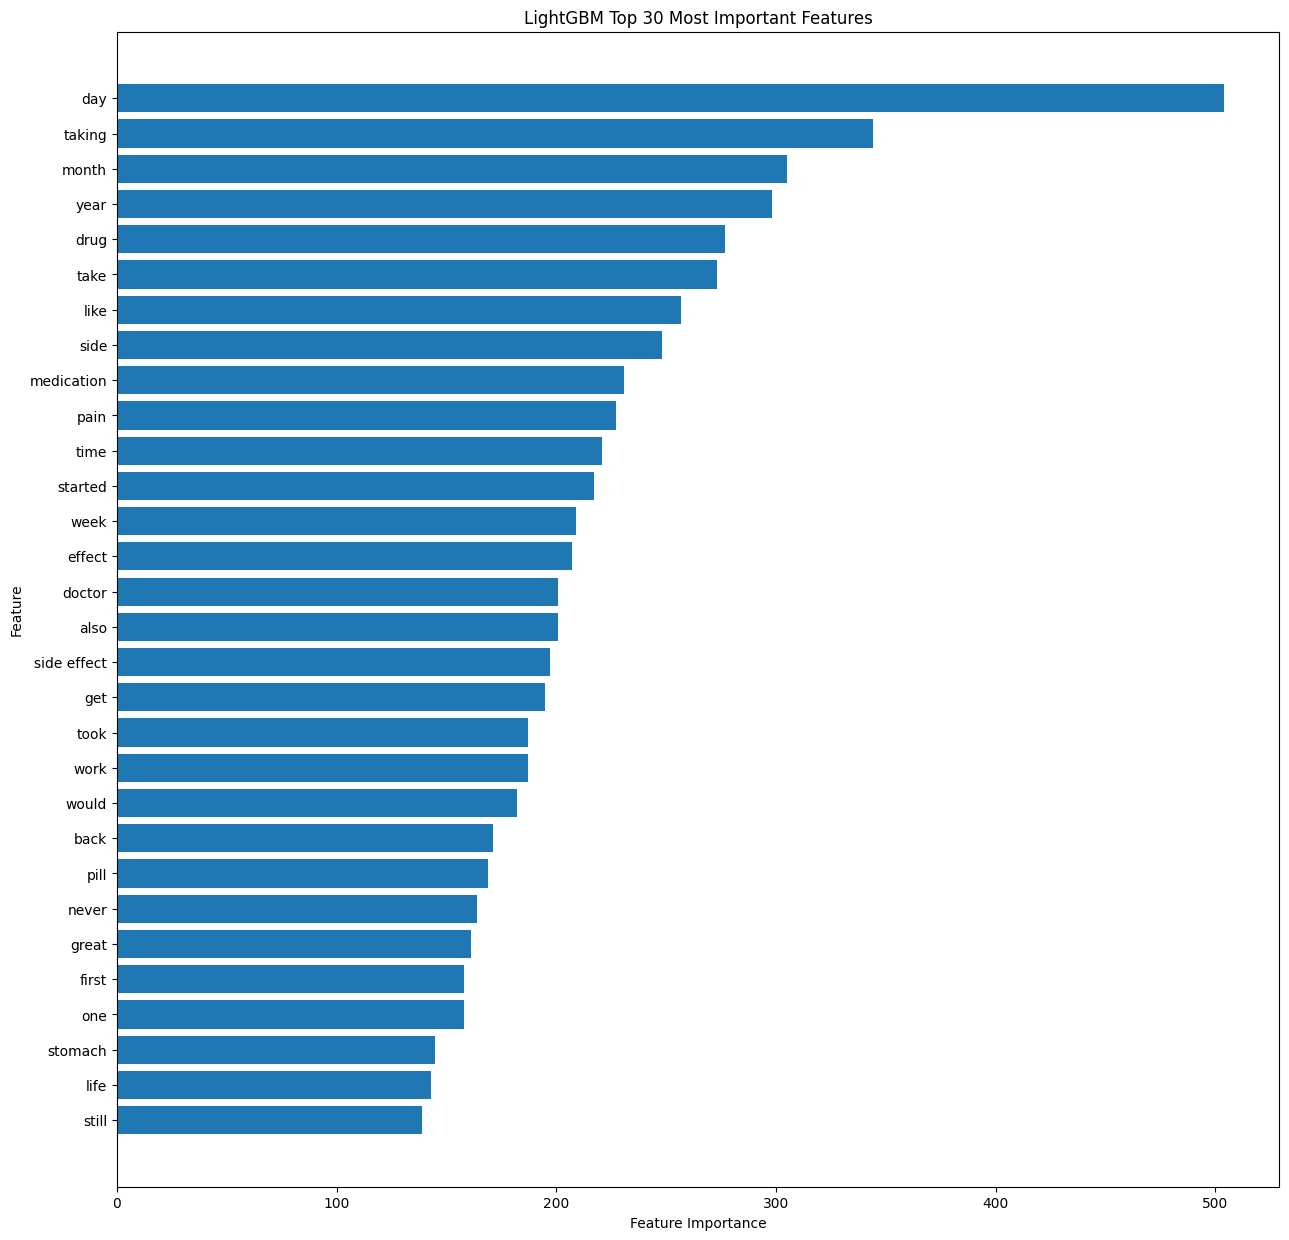

In [26]:
# Feature importance LightGBM
feature_importance = lgb_random1.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Top 30
n = 30
plt.figure(figsize=(15, 15))
plt.barh(range(n), feature_importance_df['Importance'].head(n), align='center')
plt.yticks(range(n), feature_importance_df['Feature'].head(n))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('LightGBM Top 30 Most Important Features')
plt.gca().invert_yaxis()
plt.savefig('/content/drive/MyDrive/3_classes/LGBM_featureimportance', dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

## SVC unigrams and bigrams without additional features 

In [226]:
# Perform scaling voor SVM, run for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [167]:
# Hyperparameter tuning SVC GidSearch
start_time = time.time()

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
    'decision_function_shape': ['ovr'],
    'class_weight': ['balanced'], 
} 

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)   
svm_classifier = SVC(random_state=42)
svm_random = GridSearchCV(estimator=svm_classifier,
                                param_grid=param_grid,                
                                cv=k_fold,                        
                                scoring='neg_mean_absolute_error',          
                                n_jobs=5,
                                verbose = 3)  

svm_random.fit(X_train, y_train)

print("Best Parameters:", svm_random.best_params_)
print("Best score found: ",-svm_random.best_score_)
print ('Best estimator:', svm_random.best_estimator_)

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Execution time: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf;, score=-0.996 total time=15.1min
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=rbf;, score=-0.996 total time=16.2min
[CV 4/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=-0.997 total time=16.7min
[CV 5/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.001, kernel=rbf;, score=-0.702 total time=16.0min
[CV 3/5] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.0001, kernel=rbf;, score=-0.659 total time=15.6min
[CV 3/5] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf;, score=-0.994 total time=27.8min
[CV 5/5] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=rbf;, score=-0.991 total time=23.1min
[CV 4/5] END C=1, class_weight=balanced, dec

In [168]:
# Save Gridsearch and 5CV results 
SVC_UB_nofeat_CV = pd.DataFrame(svm_random.cv_results_)
SVC_UB_nofeat_CV.to_csv('SVC_UB_nofeat_CV.csv', index=False)
box_fig = pd.read_csv('SVC_UB_nofeat_CV.csv')

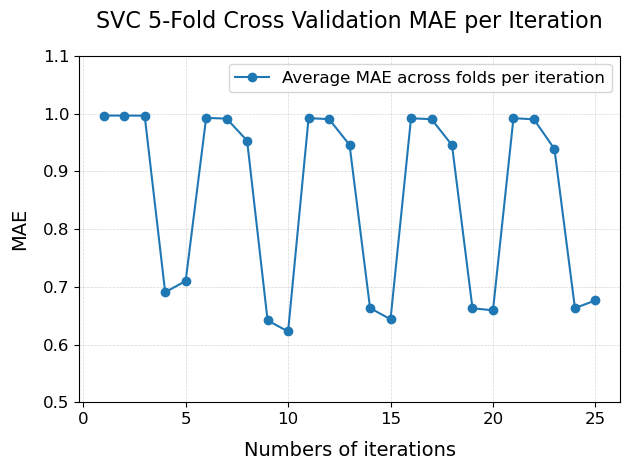

In [169]:
# Plot MAE scores average per cross validation
cv_scores = -box_fig['mean_test_score']
plt.plot(range(1, len(cv_scores) + 1), cv_scores, '-o', label='Average MAE across folds per iteration', color='#1f77b4')

plt.xlabel('Numbers of iterations', fontsize=14, labelpad=10)
plt.ylabel('MAE', fontsize=14, labelpad=10)
plt.title('SVC 5-Fold Cross Validation MAE per Iteration', fontsize=16, pad=20)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0.5, 1.1)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('SVC_avg_mae_iteration', dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

In [170]:
# Trained SVC predict test data with best estimator
svm_random1 = svm_random.best_estimator_
y_pred = svm_random1.predict(X_test)

Test MAE: 0.631
Test RMSE: 0.964
Test CWK: 0.319


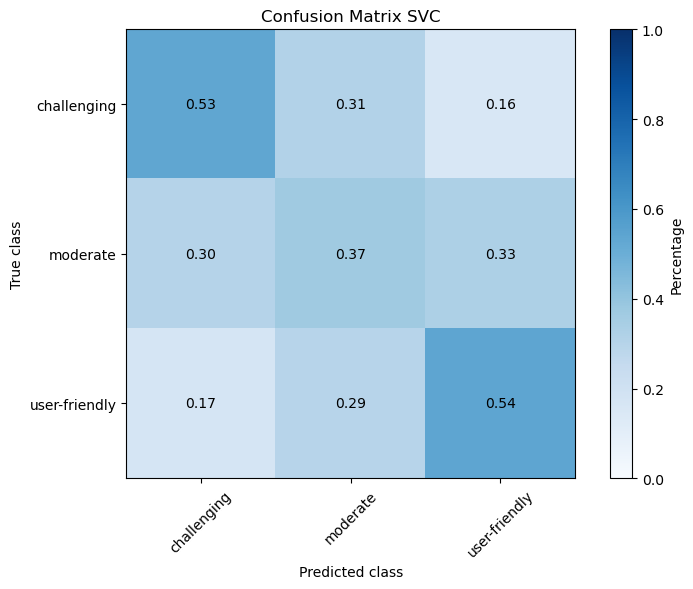

In [171]:
# Evaluation
svc_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {svc_mae:.3f}')
svc_mse = mean_squared_error(y_test, y_pred)
svc_rmse = svc_mse ** 0.5
print(f'Test RMSE: {svc_rmse:.3f}')
svc_kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Test CWK: {svc_kappa:.3f}')

# Confusion matrix
class_labels = {1: 'challenging', 2: 'moderate', 3: 'user-friendly'}
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_percent, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix SVC')
plt.colorbar(label='Percentage')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix_percent[i, j]:.2f}', ha='center', va='center', color='black')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(np.arange(len(class_labels)), [class_labels[i] for i in sorted(class_labels)], rotation=45)
plt.yticks(np.arange(len(class_labels)), [class_labels[i] for i in sorted(class_labels)])
plt.tight_layout()
plt.savefig('SVC_confusionmatrixTB', dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()